# GPの関数同定問題への適用

This program is distributed under a GPL license. The original source code is given by Tiny Genetic Programming in Python (https://github.com/moshesipper/tiny_gp). Here, some Japanese comments are added to the original code.

________________________
gen: 0 , best_of_run_f: 0.646 , best_of_run:
sub
   add
      0
      add
         mul
            0
            2
         x
   sub
      0
      1
________________________
gen: 11 , best_of_run_f: 0.802 , best_of_run:
sub
   mul
      sub
         add
            sub
               1
               -2
            add
               x
               -2
         sub
            sub
               add
                  0
                  0
               x
            1
      add
         0
         x
   sub
      add
         mul
            sub
               sub
                  -2
                  -1
               mul
                  1
                  -1
            sub
               x
               x
         sub
            -1
            -1
      1
________________________
gen: 44 , best_of_run_f: 0.828 , best_of_run:
sub
   add
      mul
         mul
            add
               mul
                  add
                     add
             

________________________
gen: 97 , best_of_run_f: 1.0 , best_of_run:
sub
   add
      sub
         add
            -1
            -1
         add
            0
            -1
      add
         add
            mul
               mul
                  x
                  add
                     mul
                        -2
                        mul
                           add
                              mul
                                 1
                                 1
                              add
                                 -2
                                 1
                           sub
                              0
                              0
                     x
               add
                  add
                     mul
                        mul
                           x
                           1
                        add
                           sub
                              0
                              1
            

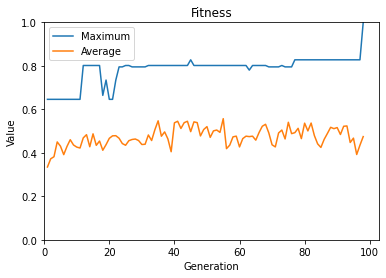

In [2]:
from random import random, randint, seed
from statistics import mean
from copy import deepcopy
import matplotlib.pyplot as plt

%matplotlib inline

POP_SIZE        = 60   # 集団サイズ（個体数）
MIN_DEPTH       = 2    # 初期の最小の木の深さ
MAX_DEPTH       = 5    # 初期の最大の木の深さ
GENERATIONS     = 250  # 最大世代数
TOURNAMENT_SIZE = 5    # トーナメント選択のサイズ
XO_RATE         = 0.8  # 交叉率 
PROB_MUTATION   = 0.2  # 突然変異率 

def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
FUNCTIONS = [add, sub, mul]
TERMINALS = ['x', -2, -1, 0, 1, 2] 

def target_func(x): # ターゲット関数（真の関数）
    return x*x*x*x + x*x*x + x*x + x + 1

def generate_dataset(): # ターゲット関数から101個のデータ点を生成
    dataset = []
    for x in range(-100,101,2): 
        x /= 100
        dataset.append([x, target_func(x)])
    return dataset

class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def compute_tree(self, x): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.compute_tree(x), self.right.compute_tree(x))
        elif self.data == 'x': return x
        else: return self.data
            
    def random_tree(self, grow, max_depth, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)

    def mutation(self):
        if random() < PROB_MUTATION: # mutate at this node
            self.random_tree(grow = True, max_depth = 2)
        elif self.left: self.left.mutation()
        elif self.right: self.right.mutation() 

    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r

    def build_subtree(self): # count is list in order to pass "by reference"
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.build_subtree()
        if self.right: t.right = self.right.build_subtree()
        return t
                        
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None              
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)  
            return ret

    def crossover(self, other): # xo 2 trees at random nodes
        if random() < XO_RATE:
            second = other.scan_tree([randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree
# end class GPTree
                   
def init_population(): # ramped half-and-half
    pop = []
    for md in range(3, MAX_DEPTH + 1):
        for i in range(int(POP_SIZE/6)):
            t = GPTree()
            t.random_tree(grow = True, max_depth = md) # grow
            pop.append(t) 
        for i in range(int(POP_SIZE/6)):
            t = GPTree()
            t.random_tree(grow = False, max_depth = md) # full
            pop.append(t) 
    return pop

def fitness(individual, dataset): # inverse mean absolute error over dataset normalized to [0,1]
    return 1 / (1 + mean([abs(individual.compute_tree(ds[0]) - ds[1]) for ds in dataset]))
                
def selection(population, fitnesses): # select one individual using tournament selection
    tournament = [randint(0, len(population)-1) for i in range(TOURNAMENT_SIZE)] # select tournament contenders
    tournament_fitnesses = [fitnesses[tournament[i]] for i in range(TOURNAMENT_SIZE)]
    return deepcopy(population[tournament[tournament_fitnesses.index(max(tournament_fitnesses))]]) 

def selection_r(population, fitnesses): # select one individual using tournament selection
    f_total = sum(fitnesses); p = random(); sum_fit = 0
    for i in range(POP_SIZE):
        sum_fit += fitnesses[i]
        if p < sum_fit / f_total:
            return deepcopy(population[i])
    
def main():      
    # init stuff
    seed() # init internal state of random number generator
    dataset = generate_dataset()
    population= init_population() 
    best_of_run = None
    best_of_run_f = 0
    best_of_run_gen = 0
    fitnesses = [fitness(population[i], dataset) for i in range(POP_SIZE)]
    average_f = []; max_f = []; gen_l = [];
    # go evolution!
    for gen in range(GENERATIONS):
        gen_l.append(gen + 1)      
        nextgen_population=[]
        for i in range(POP_SIZE):
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            parent1.crossover(parent2)
            parent1.mutation()
            nextgen_population.append(parent1)
        population=nextgen_population
        fitnesses = [fitness(population[i], dataset) for i in range(POP_SIZE)]
        average_f.append(sum(fitnesses) / len(fitnesses))# for figure
        max_f.append(max(fitnesses))# for figure
        if max(fitnesses) > best_of_run_f:
            best_of_run_f = max(fitnesses)
            best_of_run_gen = gen
            best_of_run = deepcopy(population[fitnesses.index(max(fitnesses))])
            print("________________________")
            print("gen:", gen, ", best_of_run_f:", round(max(fitnesses),3), ", best_of_run:") 
            best_of_run.print_tree()
        if best_of_run_f == 1: break   
    
    print("\n\n_________________________________________________\nEND OF RUN\nbest_of_run attained at gen " + str(best_of_run_gen) +\
          " and has f=" + str(round(best_of_run_f,3)))
    best_of_run.print_tree()
    print(len(gen_l))
    print(len(max_f))
    plt.plot(gen_l, max_f,label = "Maximum")
    plt.plot(gen_l, average_f,label = "Average")
    plt.ylim(0,1)
    plt.xlim(0,)
    plt.title('Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.legend()

main()